In [1]:
# Import live code changes in
%load_ext autoreload
%autoreload 

from pathlib import Path
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
from matplotlib.colors import ListedColormap, BoundaryNorm
from sovereign.flood import build_basin_curves, BasinLossCurve, risk_data_future_shift, run_simulation, extract_sectoral_losses
from sovereign.macroeconomic import run_flood_sim_for_macro

In [2]:
root = Path.cwd().parent # find project root
risk_basin_path = os.path.join(root, 'outputs', 'flood', 'risk', 'basins', 'risk_basins.csv')
copula_path = os.path.join(root, 'outputs', 'flood', 'dependence', 'copulas')
risk_data = pd.read_csv(risk_basin_path)
future_rp_shifts = pd.read_csv(os.path.join(root, 'outputs', 'flood', 'future', 'basin_rp_shifts.csv'))
copula_random_numbers = pd.read_parquet(os.path.join(copula_path, "copula_random_numbers.gzip"))
macro_presim = pd.read_csv(os.path.join(root, 'outputs', 'macro', 'DIGNAD_presim_n500_noadapt.csv'))
# Drop first "unnamed column"
risk_data = risk_data.iloc[:, 1:]
# Add AEP column
risk_data['AEP'] = 1 / risk_data['RP']
# Add a column converting current prorection level into AEP
risk_data['Pr_L_AEP'] = np.where(risk_data['Pr_L'] == 0, 0, 1 / risk_data['Pr_L']) # using numpy where avoids zero division errors
risk_data.reset_index(drop=True, inplace=True)

In [3]:
adaptation_aep = 0.01 # 100-year flood protection
n_years = 10000 # number of years to simulate
Thai_GDP = 496e9 # 2022 numbers in USD
# future_hydro = 'jules-w2'
# future_epoch = 2070
# future_scenario = 'ssp585'
# future_stat = 'q90'
# National GVA figures from DOSE
agr_GVA = 42880325598
man_GVA = 162659433017
ser_GVA = 316647741231
# Disaggregate output losses
TRADABLE_SHARES = {
    "Agriculture": 1.0,
    "Manufacturing": 0.7,
    "Service": 0.5,
}

In [4]:
# Build basin loss probability curves
baseline_curves: dict[int, BasinLossCurve] = build_basin_curves(risk_data)

In [5]:
# Run baseline simulation
baseline_losses, baseline_adapted_losses = run_simulation(baseline_curves, n_years, adaptation_aep, copula_random_numbers)

100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1088.51it/s]


In [6]:
# Run baseline macro sim
baseline_current_df, baseline_adapted_df = run_flood_sim_for_macro(
    baseline_curves, adaptation_aep, n_years, copula_random_numbers,
    agr_GVA, man_GVA, ser_GVA, TRADABLE_SHARES, Thai_GDP
)

100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1065.64it/s]


In [9]:
pd.DataFrame(baseline_losses).to_csv('baseline_losses.csv')
baseline_current_df.to_csv('baseline_losses_macro_input.csv')

In [8]:
# Create interpolators
X = macro_presim[['dY_T', 'dY_N', 'dK_priv', 'dK_pub']].values
y = macro_presim['gdp_avg'].values

linear_interp = LinearNDInterpolator(X, y)
nearest_interp = NearestNDInterpolator(X, y)

# Interpolation function for monte carlo analysis
def interpolate_gdp(params):
    gdp = linear_interp(params)
    if np.isnan(gdp): # if outside convex hull
        gdp = nearest_interp(params)
    if np.all(params == 0): # no disaster
        gdp = 0.0
    return gdp

In [9]:
interp_GDP = []
for row in tqdm(baseline_current_df.itertuples(index=False), total=len(baseline_current_df), desc="Running Interpolation Evaluation"):
    # Extract shock parameters
    year = row.year_index
    dY_T = row.dY_T
    dY_N = row.dY_N
    dK_priv = row.dK_priv
    dK_pub = row.dK_pub
    # Run interpolation
    params = [dY_T, dY_N, dK_priv, dK_pub]
    gdp = interpolate_gdp(params)[0]
    interp_GDP.append({
        "year_index": year,
        "gdp": gdp
    })

Running Interpolation Evaluation: 100%|█| 10000/10000 [00:00<00:00, 35582.37it/s


In [15]:
macro_impacts = pd.DataFrame(interp_GDP)

In [17]:
macro_impacts.to_csv("macro_sim.csv", index=False)

In [50]:
losses = macro_impacts['gdp'].values

In [52]:
losses = -losses 
losses_sorted = np.sort(losses)[::-1]
n = len(losses_sorted)
exceedance_prob = np.arange(1, n + 1) / n

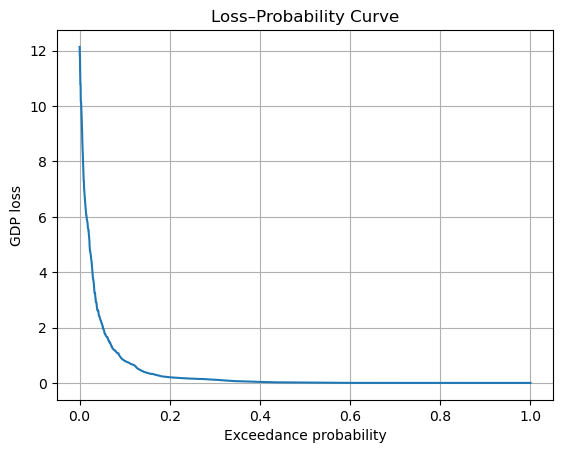

In [59]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(exceedance_prob, losses_sorted)
plt.xlabel("Exceedance probability")
plt.ylabel("GDP loss")
plt.title("Loss–Probability Curve")
plt.grid(True)
plt.show()

In [62]:
p1  = np.percentile(losses_sorted, 99)   # 1% worst loss
p5  = np.percentile(losses_sorted, 95)   # 5% worst loss
p10 = np.percentile(losses_sorted, 90)  # 10% worst loss

In [63]:
print(p1)
print(p5)
print(p10)

7.043990844456347
2.1035316976306024
0.7978352559051903
